In [1]:
import os
import sys
import sqlite3
import numpy as np
import pandas as pd
import geopandas as gp
import plotly.express as px
import skill_metrics as sm
import skill_metrics as sm
import matplotlib.pyplot as plt
import scipy.stats as scs

In [2]:
sys.path.append('/home/pooya/w/DroughtMonitoringIran/')

DATABASE_PATH = "./database/database.db"

### Monthly Data

In [3]:
conn = sqlite3.connect(DATABASE_PATH)

data = pd.read_sql(sql='SELECT * FROM data', con=conn)

conn.close()

### Columns

In [7]:
data.columns.to_list()

['Station_ID',
 'Station_Name',
 'Province',
 'Station_Latitude',
 'Station_Longitude',
 'Station_Elevation',
 'Date',
 'Temperature_Maximum',
 'Temperature_Minimum',
 'Temperature',
 'Precipitation',
 'PET_Hargreaves',
 'SPI_1',
 'SPEI_1',
 'SPI_3',
 'SPEI_3',
 'SPI_6',
 'SPEI_6',
 'SPI_9',
 'SPEI_9',
 'SPI_12',
 'SPEI_12',
 'SPI_15',
 'SPEI_15',
 'SPI_18',
 'SPEI_18',
 'SPI_21',
 'SPEI_21',
 'SPI_24',
 'SPEI_24',
 'ERA5_Precipitation',
 'GPM_Precipitation',
 'TRMM_Precipitation',
 'TERRACLIMATE_Precipitation',
 'PERSIANNCDR_Precipitation',
 'PET_MOD16A2GF',
 'NDVI_MOD13A3',
 'LSTDay_MOD21C3',
 'LSTNight_MYD21C3',
 'EVI_MYD13A3',
 'LSTNight_MOD21C3',
 'NDVI_MYD13A3',
 'LSTDay_MYD21C3',
 'EVI_MOD13A3',
 'NDVI',
 'EVI',
 'LSTDay',
 'LSTNight',
 'LST',
 'PCI_ERA5',
 'PCI_GPM',
 'PCI_TRMM',
 'PCI_TerraClimate',
 'PCI_PERSIANNCDR',
 'VCI',
 'TCI',
 'VHI',
 'CI_GPM',
 'CI_ERA5',
 'CI_TRMM',
 'CI_TerraClimate',
 'CI_PERSIANNCDR',
 'ERA5_SPI_1',
 'ERA5_SPEI_1',
 'GPM_SPI_1',
 'GPM_SPEI_1',
 '

'Station_ID', 'Station_Name', 'Province', 'Date', 'Precipitation', 'ERA5_Precipitation', 'GPM_Precipitation', 'TRMM_Precipitation', 'TERRACLIMATE_Precipitation', 'PERSIANNCDR_Precipitation',

### Unique Station

In [10]:
data[['Station_ID', 'Station_Name']].drop_duplicates().reset_index(drop=True)

,Station_ID,Station_Name
0,40709,Astara
1,40718,Bandar-e-anzali
2,40719,Rasht
3,40720,Manjil
4,40732,Ramsar
5,40734,Nowshahr
6,40735,Siahbisheh
7,40736,Babolsar
8,40737,Gharakhil
9,40759,Sari


### Select Stations
- Cluster 3 - Bandar-e-anzali:  40718  
- Cluster 1 - Gharakhil:        40737  
- Cluster 2 - Siahbisheh:       40735  

In [28]:
selected_stations = ["Bandar-e-anzali", "Gharakhil", "Siahbisheh"]

### TaylorDiagram Precip (for each station)

/home/pooya/w/DroughtMonitoringIran/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:4062: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


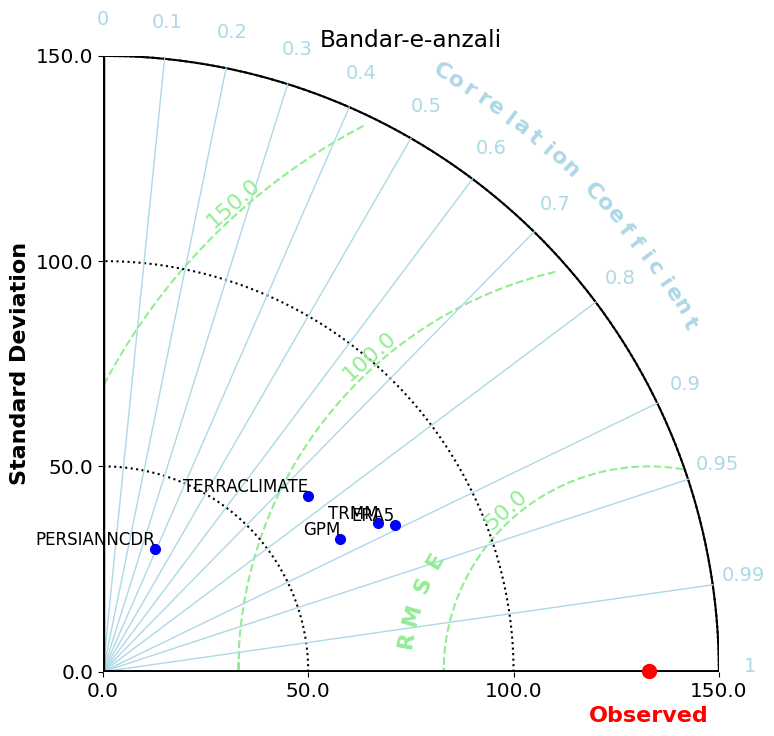

/home/pooya/w/DroughtMonitoringIran/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:4062: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


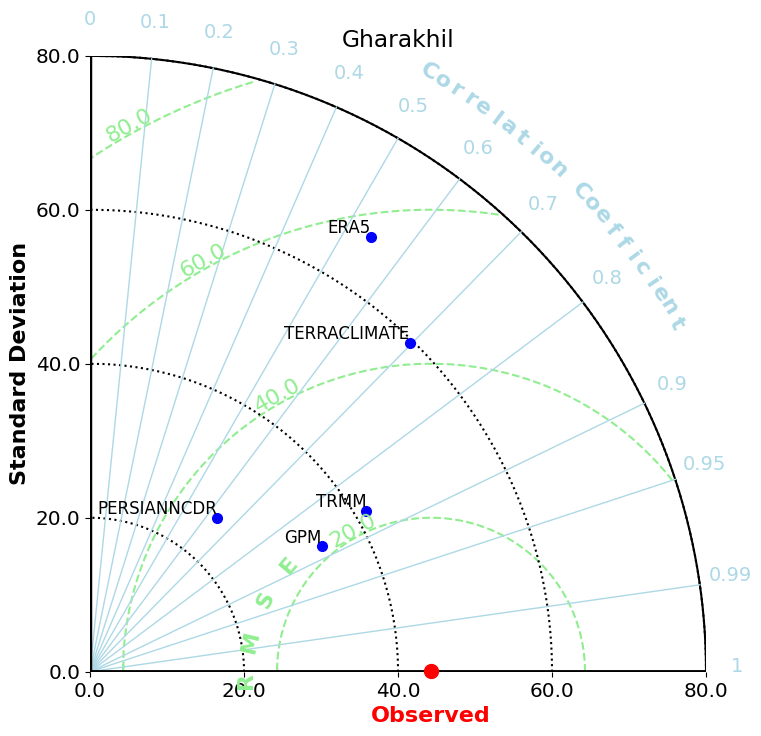

/home/pooya/w/DroughtMonitoringIran/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:4062: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


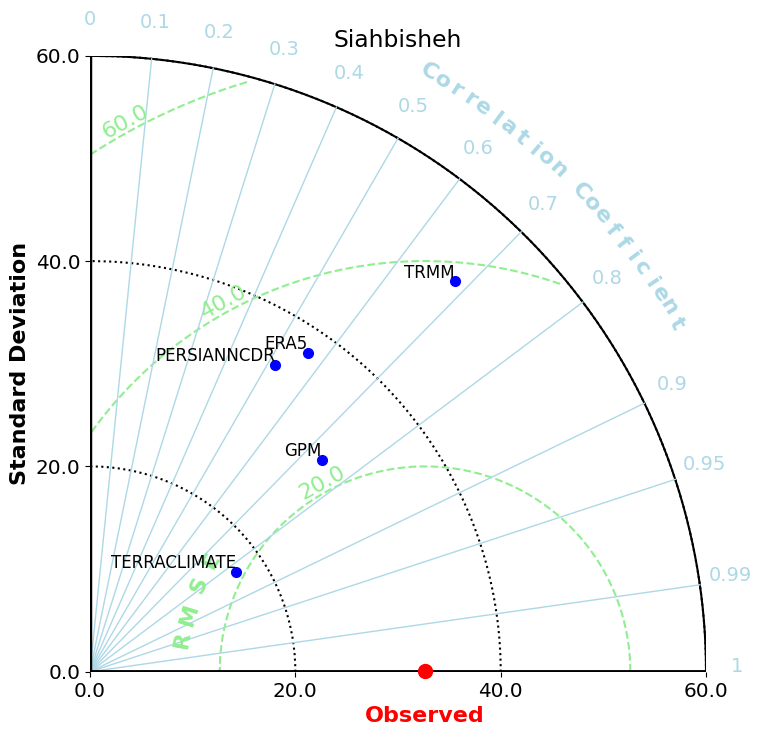

In [29]:
for sti in selected_stations:
    df = data.query(f"Station_Name == '{sti}'")
    
    model_names = ['ERA5', 'GPM', 'TRMM', 'TERRACLIMATE', 'PERSIANNCDR']
    stddevs = []
    correlations = []
    rmses = []
    std_obss = []

    for model in model_names:
        valid_data = df[['Precipitation', f"{model}_Precipitation"]].dropna()
        observed = valid_data['Precipitation'].values
        modeled = valid_data[f"{model}_Precipitation"].values

        std_model = np.std(modeled)
        std_obs = np.std(observed)
        cor = np.corrcoef(observed, modeled)[0, 1]
        # rmse = np.sqrt(std_model**2 + std_obs**2 - 2 * std_model * std_obs * cor)
        rmse = np.sqrt(np.mean((observed - modeled) ** 2))
        
        stddevs.append(std_model)
        correlations.append(cor)
        rmses.append(rmse)
        std_obss.append(std_obs)

        
    stddevs.insert(0, np.std(df[['Precipitation']].dropna()).values[0])
    rmses.insert(0, 0)
    correlations.insert(0, 1)

    stddevs = np.array(stddevs)
    correlations = np.array(correlations)
    rmses = np.array(rmses)
    std_obss = np.array(std_obss)

    plt.rcParams.update({'font.size': 14})
    fig, ax = plt.subplots(figsize=(8, 8))
    sm.taylor_diagram(
        stddevs, rmses, correlations,
        markerdisplayed='marker',
        markerLabel=['Observed'] + model_names,
        markerColor='blue',
        markerSize=14,
        colCOR='lightblue',
        colrms='lightgreen',
        colstd='black',
        styleCOR='-',
        widthCOR=1,
        titleOBS='Observed',
        # styleOBS='-',
        colOBS='red',
        labelrms="RMSE",
        markerobs = 'o'
    )
    # plt.legend(loc="upper right")
    plt.title(f"{sti}")
    plt.show()

### Calculate Model Evaluator

In [34]:
from utils.model_evaluator import ModelEvaluator
for pr_model in ['ERA5', 'GPM', 'TRMM', 'TERRACLIMATE', 'PERSIANNCDR']:
    for sid, df in data.query("Station_Name in @selected_stations").groupby(by='Station_Name'):
        print(f"\nMetrics for Station ID: {sid} and Precip Model: {pr_model}")
        ModelEvaluator(df, 'Precipitation', f'{pr_model}_Precipitation').display_metrics()


Metrics for Station ID: Bandar-e-anzali and Precip Model: ERA5
Model Performance Metrics:
Mean Absolute Error (MAE): 54.2426
Mean Squared Error (MSE): 6984.4145
Root Mean Squared Error (RMSE): 83.5728
R-squared (R2): 0.6049
Explained Variance Score: 0.7115
Willmott's Index of Agreement (WI): 0.7039
Nash–Sutcliffe Efficiency (NS): 0.6049
Mean Absolute Deviation (MAD): 54.2426

Metrics for Station ID: Gharakhil and Precip Model: ERA5
Model Performance Metrics:
Mean Absolute Error (MAE): 84.2902
Mean Squared Error (MSE): 10120.9384
Root Mean Squared Error (RMSE): 100.6029
R-squared (R2): -4.1612
Explained Variance Score: -0.6594
Willmott's Index of Agreement (WI): 0.2950
Nash–Sutcliffe Efficiency (NS): -4.1612
Mean Absolute Deviation (MAD): 84.2902

Metrics for Station ID: Siahbisheh and Precip Model: ERA5
Model Performance Metrics:
Mean Absolute Error (MAE): 45.6659
Mean Squared Error (MSE): 3067.6275
Root Mean Squared Error (RMSE): 55.3862
R-squared (R2): -1.8818
Explained Variance Sco

In [55]:
import plotly.express as px

for st in selected_stations:
    station_data = data.query("Station_Name == @st")[['Date', 'Precipitation', 'GPM_Precipitation']].dropna()
    fig = px.scatter(station_data, x='Precipitation', y='GPM_Precipitation', title=st)
    max_limit = max(station_data['Precipitation'].max(), station_data['GPM_Precipitation'].max())
    fig.update_layout(xaxis=dict(range=[0, max_limit]), yaxis=dict(range=[0, max_limit]))
    fig.update_yaxes(scaleanchor="x", scaleratio=1)
    fig.update_xaxes(constrain='domain')
    fig.show()